In [77]:
"""
author: Kilvoctu
date: 2023.
title: stable-diffusion-webui
version: This is the forked version by Jie Ma
type: source code
URL: Downloaded by Jie Ma July 11th,2023 from url:https://github.com/AUTOMATIC1111/stable-diffusion-webui/wiki/API
"""

#get api
import json
import requests
import io
import base64
from PIL import Image, PngImagePlugin

url = "http://127.0.0.1:7860" # stable diffusion local URL 

option_payload = { #Here we construct a parametric architecture for reading preprocessing models
    
#     "sd_model_checkpoint": "anything-v5-PrtRE.safetensors [7f96a1a9ca]",
    "sd_model_checkpoint": "Anything-v4.5-pruned-mergedVae.safetensors [a504b5b137]",
    
    #This setting indicates the number of layers on the model.
    #Lower number means higher layers.
    "CLIP_stop_at_last_layers": 2
}

#Send payload to stable diffusion to request a reply
response = requests.post(url=f'{url}/sdapi/v1/options', json=option_payload)

payload = { #Here we construct a parameter architecture for setting the parameters of the model
    
    #Textual keywords describing the generated image, which control the content of the generated image.
    
#     "prompt": "(finely detailed beautiful eyes and detailed face,masterpiece sidelighting,masterpiece,best quality,detailed,high resolution illustration)\
#     ,(urban techwear, fantasy background, village,tree,woods),\
#     (1girl,whole body,bishoujo,lustrous skin,looking down,looking at viewer),\
#     (black hair,blue eyes,black short skirt,ribbon,button shirt:1.2)",
    "prompt": "(a black dog),(no humans),(animal focus),", 
    
    #Controls the number of denoising steps, the higher the number the more detailed the image.
    "steps": 20,
    
    #This parameter ranges from 0 to 1, where 0 adds no noise at all.
    #This parameter represents the degree by which the initial image being supplied is redrawn, 
    #and is typically applied in img2img.
    "denoising_strength": 0.5,
    
    #Seed, used to determine the number of initial random noise
    "seed": -1,
    
    #Number of images generated per run - n number of images
    "batch_size": 1,
    
    #Number of iterations performed - n_iter rounds
    "n_iter": 1,
    
    #represents the degree of influence of text on image generation
    #the higher it is the more relevant the generated image is to the prompt
    "cfg_scale": 7,
    
    "width": 512,
    "height": 768,
    
    #Negative emojis represent tags to be avoided in the images generated by the model
    #generally these are the ones that don't need to be modified
    "negative_prompt": "(worst quality:1.6),(low quality:1.6), ng_deepnegative_v1_75t", 
    
    #Modify the parameters of the illustration style
    "sampler_index": "DPM++ 2M Karras" 
}

#Send payload to stable diffusion to request a reply
response = requests.post(url=f'{url}/sdapi/v1/txt2img', json=payload) 

#Convert the requested text into json format
r = response.json()

#Read the base64 encoding information of an image from response
for i in r['images']: 
    
    #Read image from memory(RAM) with png format by base64 decoding
    image = Image.open(io.BytesIO(base64.b64decode(i.split(",",1)[0])))

    png_payload = {
        "image": "data:image/png;base64," + i
    }
    
    #Send payload to RAM to request a reply
    response2 = requests.post(url=f'{url}/sdapi/v1/png-info', json=png_payload)
    
    #Save the image's info 'info' like 'gamma' to prevent distortion.
    pnginfo = PngImagePlugin.PngInfo() 
    pnginfo.add_text("parameters", response2.json().get("info")) 
    image.save('test_img/output_dog.png', pnginfo=pnginfo)

KeyError: 'images'

In [ ]:
r

In [2]:
"""
author: Mason-McGough
date: 2023.
title: A simple script that removes people from photos using the stable-diffusion-webui API
version: This is the forked version by Jie Ma
type: source code
URL: Downloaded by Jie Ma August 1th,2023 from https://gist.github.com/Mason-McGough/9733aff5bc9d04faecfbb81074617315
"""

import torch
from torchvision.models.segmentation import fcn_resnet101, FCN_ResNet101_Weights
from torchvision.io.image import read_image
from torchvision.utils import draw_segmentation_masks
import matplotlib.pyplot as plt
import matplotlib.image as mpimg # mpimg For reading images

img_path = 'test_img/output_dog.png'#output png
    
# Load model

#Reading the parameters of the FCN101 detection model
weights=FCN_ResNet101_Weights.DEFAULT 

#set the fcn101 model
model = fcn_resnet101(weights=weights, progress=False)
model = model.eval()

# Load image
img = read_image(img_path)

# Run model
#The transformation parameter is the tensor
input_tform = weights.transforms(resize_size=None)

# Connect the image as in the tensor
batch = torch.stack([input_tform(img)])

# Let the model detect images and output detection tensors
output = model(batch)['out'] 

# Returns a dictionary of 21 detection tensors
sem_class_to_idx = {cls: idx for (idx, cls) in enumerate(weights.meta['categories'])} 

#Do a softmax operation on the columns of each dimension of the output
#in order to extract the detection masks
normalized_mask = torch.nn.functional.softmax(output, dim=1) 

In [3]:
sem_class_to_idx 

{'__background__': 0,
 'aeroplane': 1,
 'bicycle': 2,
 'bird': 3,
 'boat': 4,
 'bottle': 5,
 'bus': 6,
 'car': 7,
 'cat': 8,
 'chair': 9,
 'cow': 10,
 'diningtable': 11,
 'dog': 12,
 'horse': 13,
 'motorbike': 14,
 'person': 15,
 'pottedplant': 16,
 'sheep': 17,
 'sofa': 18,
 'train': 19,
 'tvmonitor': 20}

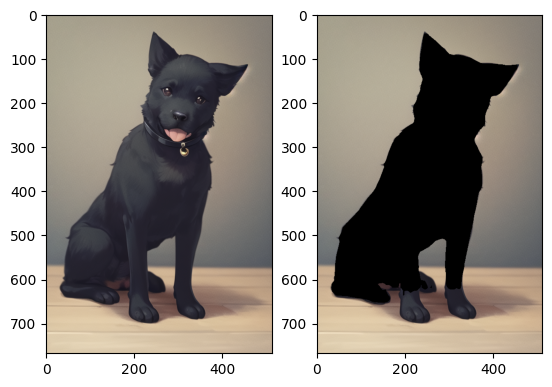

In [4]:
# Show results
class_idx = 1
#Extract the mask with dog
binary_masks = (normalized_mask.argmax(class_idx) == sem_class_to_idx['dog']) 
#Split mask on a given RGB image, alpha=1 for full opacity.
img_masked = draw_segmentation_masks(img, masks=binary_masks, alpha=1) 
plt.subplot(1, 2, 2)
#Show mask image
plt.imshow(img_masked.permute(1, 2, 0).numpy()) 
plt.subplot(1, 2, 1)
#Show original image
img_ori = mpimg.imread(img_path) 
plt.imshow(img_ori)
plt.show()

-------------------------------------------exact mask-----------------------------------------------

In [5]:
"""
author: Mason-McGough
date: 2023.
title: A simple script that removes people from photos using the stable-diffusion-webui API
version: This is the forked version by Jie Ma
type: source code
URL: Downloaded by Jie Ma August 1th,2023 from https://gist.github.com/Mason-McGough/9733aff5bc9d04faecfbb81074617315
"""
import io
import base64
from PIL import Image, PngImagePlugin
from torchvision import transforms
from torchvision.io.image import read_image

def img_encode64(img): #Convert png images to base64 encoding
    buffered = io.BytesIO() #Creating a RAM request and caching the image in RAM
    img.save(buffered, format='PNG')
    return base64.b64encode(buffered.getvalue()).decode("utf-8") #base64 encoding here

# Extract mask

#Convert tensor to PIL image (MAKE A METHOD HERE)
tensor_to_pil = transforms.ToPILImage() 
#Extract the mask with dog
mask = normalized_mask[0, sem_class_to_idx['dog']] 
mask = mask > 0.5

# Convert images to base64
#read the original img
img = read_image(img_path)

#Convert tensor to PIL image
img = tensor_to_pil(img.cpu()) # convert to cpu tensor (.cpu)
#Convert png images to base64 encoding
img_b64 = img_encode64(img)

#Convert tensor to PIL image
mask = tensor_to_pil(mask.to(torch.float32).cpu()) 
#Convert png images to base64 encoding
mask_b64 = img_encode64(mask)

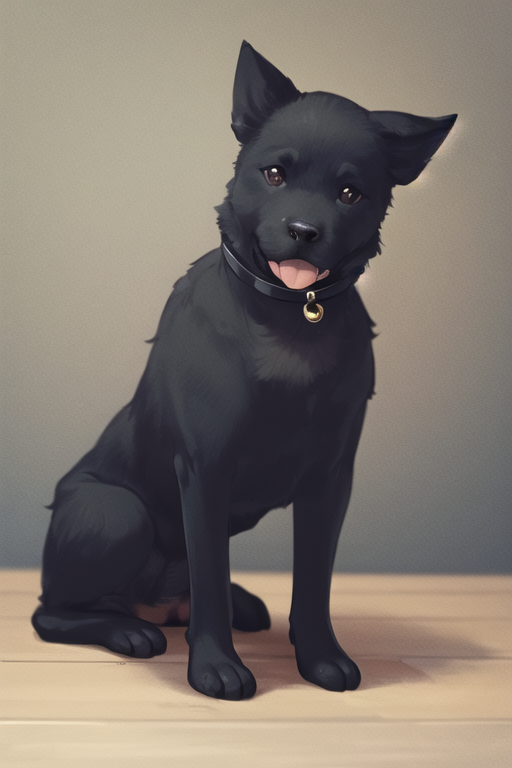

In [6]:
img

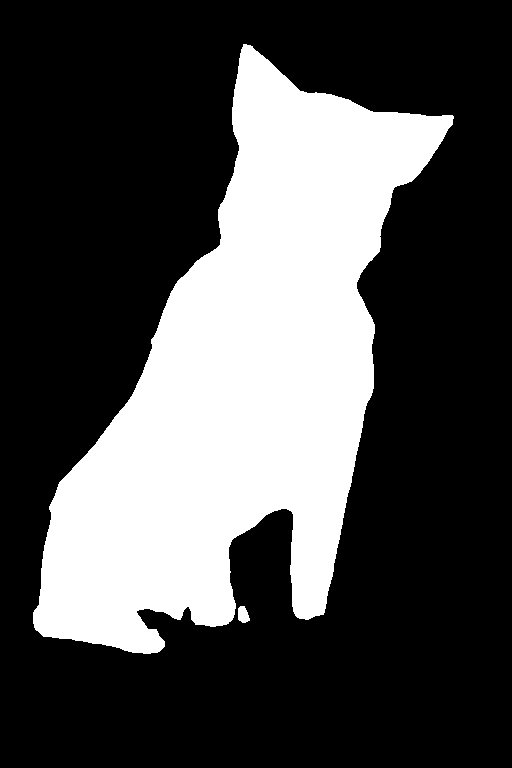

In [7]:
mask

In [8]:
mask_b64

'iVBORw0KGgoAAAANSUhEUgAAAgAAAAMACAAAAAB3ZICSAAAOs0lEQVR4nO3d2Xoby7FE4aY/vf8rwxcSuQkSQw+VVREZ67+xfbyPBHQuZDXAwdsGAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABW+lj9ABa4bZnP+6HEC3H796+Jz/2X/61+AAvdbu//mfYCA2Ds3wUG8A0tBAZwe/ofIuUFcC++gPQA4u8E4wNIXwJxATwYd3QBcQE8klwAAWxb9I0AAfwVWwAB/JNaQFoAz+ccWkBaAC9k3ggQwDeJBRDAd4EFEMCdvAII4F5cAQTwQ1oBBPBTWAFhAeyZblYBYQHsElUAATyQVAABPBJUAAE8lFMAATwWUwABPJFSAAE8E1JAVgCHhppRQFYAx0R8gwABvBJQAAG81L8AAnitfQFRAZyZZvcCogI4pXkBBPBW7wII4L3WBRDADp0LSArg/BwbF5AUwAV9CyCAfdoWQAA7dS2AAPZqWkBQAFcn2LOAoAAua1lA0G/MHjO/bhes2/N5YdgL+POa3TpcvQZPYa/KDe57GX0f+WH1R7jjxXR8zCdNuYezu552D/i8WTfxXpfU69FeMfVNnM9l9XmkV81+F29yZU0e5gArPsYxuLp8EljJ4EdLCKCWfAEEUEx9CRBAOe0ECGAC5QQIYArdBAhgEtUEDN6pjqFw/RUvNhtgIsUtQABT6SVAAJOpJaB4LJWQuu5CV13oodSSCuCp+eMgAFlzRkMADgqnRAA2fo7q9vy/uvCntuUfwCvnx8jbwHAEEI4AOrhwkBNAOAIIRwDhCCAcAYSLCaDzJ15XnltMAI1dapsA7F3bbQTg7uLZRgDmrt7bEEA4AvB2+c1NTgCd3wdekBNAS9erJoBwQQE0PAMGPKWgAPBIUgDtVsCIJ5QUAB6ICqDZChjydKICwG8EYGvMPssKoNMZMOi5ZAWAXwjA1KhlFhZAmzNg2BMJCwA/EYClcZu

------------------------------------------------img2img-----------------------------------------------

In [9]:
img = read_image('test_img/dog_dog_sample.png')

In [10]:
from torchvision import transforms

def img64(img):#Convert png images to base64 encoding
    img_buffer = io.BytesIO()#Creating a RAM request and caching the image in RAM
    img.save(img_buffer, format='PNG')
    img64_decode = base64.b64encode(img_buffer.getvalue()).decode("utf-8")#base64 encoding here
    return img64_decode

#Convert tensor to PIL image
tensor_to_pil = transforms.ToPILImage()
img = tensor_to_pil(img.cpu())# convert to cpu tensor (.cpu)
#Convert png images to base64 encoding
img_b64 = img64(img)

In [13]:
import requests
import base64

url = "http://127.0.0.1:7860" # stable diffusion local URL 
# colour = #"green","red","white","yellow","black","blue",
# colour = #"cat","dog"
colour_list = ["cat",]
for colour in colour_list:
    
    payload = {#Here we construct a parameter architecture for setting the parameters of the model
        
        #Base64 encoding of the initial image
        "init_images":[img_b64],
        
    #     "prompt":"(green hair:1.2,blue eyes,short skirt,ribbon,button shirt:1.2)",
    #     "prompt":"(red hair:1.2,blue eyes,short skirt,ribbon,button shirt:1.2)",
    #     "prompt":"(white hair:1.2,blue eyes,short skirt,ribbon,button shirt:1.2)",
    #     "prompt":"(yellow hair:1.2,blue eyes,short skirt,ribbon,button shirt:1.2)",
    #     "prompt":"(black hair:1.2,blue eyes,short skirt,ribbon,button shirt:1.2)",
    #     "prompt":"(blue hair:1.2,blue eyes,short skirt,ribbon,button shirt:1.2)",
#         "prompt":"("+f"{colour} hair,blue eyes,short skirt,ribbon,button shirt:1.2)",
        "prompt":"(a"+f"{colour}),(animal focus),",
        
        #Base64 encoding of the imask
        "mask":mask_b64,
        "steps": 20,
        "cfg_scale": 7,
#         'denoising_strength':0.6,
        
        #Inpainting Fill mode 1 means original image,0 means fill,2 means latent noise,3 means latent nothing
        'inpainting_fill':1,
#         "sampler_index": "DPM++ 2M Karras",
        "batch_size": 1,
        "width": 512,
        "height": 768,
        
        #Blurring effect on the edges of the mask (we off here)
        'mask_blur': 0,
    }

    test_sample_num = 50 #Number of images generated
    
    for j in range(test_sample_num):#Repeat 50 times to gain 50 number of images
        
        #Transfer request to stable diffusion
        response = requests.post(url=f'{url}/sdapi/v1/img2img',json=payload)

        r = response.json()

        for i in r['images']:#Read the base64 encoding information of an image from response
            
            image = Image.open(io.BytesIO(base64.b64decode(i.split(",",1)[0])))
            
            png_payload = {
                "image": "data:image/png;base64," + i
            }
            response2 = requests.post(url=f'{url}/sdapi/v1/png-info', json=png_payload)

            pnginfo = PngImagePlugin.PngInfo()
            pnginfo.add_text("parameters", response2.json().get("info"))
            image.save('baseline/test_cat_dog2'+f'{colour}/cat'+f'{j}.png', pnginfo=pnginfo)

In [14]:
colour

'cat'

In [33]:
r

{'images': ['iVBORw0KGgoAAAANSUhEUgAAAgAAAAMACAIAAADdbUgZAAAA/nRFWHRwYXJhbWV0ZXJzAChhZG9nIDoxLjIpLChhbmltYWwgZm9jdXMpLApTdGVwczogMjAsIFNhbXBsZXI6IERQTSsrIDJNIEthcnJhcywgQ0ZHIHNjYWxlOiA3LjAsIFNlZWQ6IDE3NDY1Mzg1NCwgU2l6ZTogNTEyeDc2OCwgTW9kZWwgaGFzaDogN2Y5NmExYTljYSwgTW9kZWw6IGFueXRoaW5nLXY1LVBydFJFLCBTZWVkIHJlc2l6ZSBmcm9tOiAtMXgtMSwgRGVub2lzaW5nIHN0cmVuZ3RoOiAwLjYyLCBDbGlwIHNraXA6IDIsIFZlcnNpb246IHYxLjQuMBRbfLUAAQAASURBVHicdP29rixN0gUMrcis6t4zH+ITfwYGEg5IeICNicRNcKV4SEhYXAAODj5IIHjfObsrA2OtFRF95mXPPPv07q6uyp+IFSsiIyPjf/O//l/9+fxGZiYiIvNEBMYP/0i+8Ef1en4agUT/Hfi3+8T3XwE+tG7fz5kX59ez6gaByNHC75+oxkQ9C0Di327kq7+/2X0B3L5I5Pe3x5CwM/NZ3TbegMOLr9H1s/7u+3/5NwLIv0a1/orv99IdH7/+7Xtz4Kvrybc16OxIZrpFfp28ZjY0Q/MUAQR/+GdohJc/Ydfr86wbZyJwDucqMzMT55xEnpPg7+AHQA/zd9c4Abp/Riy3vwca7lcCeTLrzb7vl7xH9wzdn78n4N+ny+/lbGr0E/L/Tx/8aUQkvqYpEOlJmr+nwHNy9F0JbYzZ8u3n7KdFuPrwff/5Zn33L7nqvlhgUr80wYGMTCBjCFVk8qN6QPB9P4oTMQQ5+fgck7YCK9YK7BUrYkWsFUDEAsWy9dS3DaNKfiPAV3cyEZHuR8kkJUeCk33zCARireDvFbH3Wiv22nvF3nuvdV39e++9176ufV3

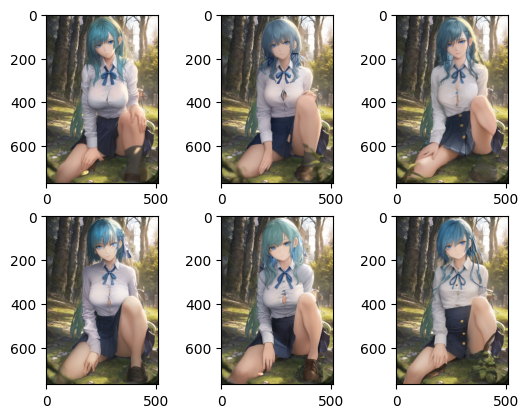

In [305]:
# Show results
for i in range(6):
    plt.subplot(2, 3, i+1)
    img_path = 'V4.5/test_hair_red2'+f'{colour}/person'+f'{i}.png'
    img_ori = mpimg.imread(img_path)
    plt.imshow(img_ori)
plt.show()

----------------------------------- evaluation img ---------------------------------------- (Use tragger)

In [1]:
origial = ["black","black","black","black","black",
           "blue","blue","blue","blue","blue",
           "green","green","green","green","green",
           "red","red","red","red","red",
           "white","white","white","white","white",
           "yellow","yellow","yellow","yellow","yellow",
           "dog","cat",]

entity_ori = ["hair","hair","hair","hair","hair",
              "hair","hair","hair","hair","hair",
              "hair","hair","hair","hair","hair",
              "hair","hair","hair","hair","hair",
              "hair","hair","hair","hair","hair",
              "hair","hair","hair","hair","hair",
              "cat","dog",]

replace = ["green","red","white","yellow","blue",
           "green","red","white","yellow","black",
           "red","white","yellow","black","blue",
           "green","white","yellow","black","blue",
           "green","red","yellow","black","blue",
           "green","red","white","black","blue",
           "cat","dog",]

entity_rep = ["person","person","person","person","person",
              "person","person","person","person","person",
              "person","person","person","person","person",
              "person","person","person","person","person",
              "person","person","person","person","person",
              "person","person","person","person","person",
              "cat","dog",]

In [2]:
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_distances
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
import numpy as np

In [3]:
#read original
count = 32
dis_max = []
dis_min = []
dis_mean = []
dis_std = []
version = ['V5','V4.5','baseline']

for v in range(3):
    for ct in range(32):
        f = open("test_img/"+f"{replace[ct]}_"+f"{entity_ori[ct]}_sample.txt")  
        lines = f.readlines()
        f.close()

        #Retrieve the label set for each image
        query =[]
        for i in range(50):
            colour_url=f'{version[v]}/test_'+f'{entity_ori[ct]}_'+f'{origial[ct]}2'+f'{replace[ct]}/'+f'{entity_rep[ct]}'+f'{i}.txt'
            f = open(colour_url) 
            line = f.readlines()
            f.close()
            query.append(line)

        list1 = lines
        cosine_distances_list = []

        for i in range(50):
            list2 = query[i]
            # create tfidf vectorizer
            tfidf_vectorizer = TfidfVectorizer()

            # fit and transform list as vectors set
            tfidf_matrix_list1 = tfidf_vectorizer.fit_transform(list1)
            tfidf_matrix_list2 = tfidf_vectorizer.transform(list2)

            # compute distances using cosine distance as cosine similarity
            distance = cosine_distances(tfidf_matrix_list1, tfidf_matrix_list2)
            cosine_distances_list.append(distance[0][0])

        #Emphasis on distance variations for amplifying the difference (Easy to observe)
        cosine_distances_list = [i*120 for i in cosine_distances_list]
        #Keep three decimals for aesthetics
        cosine_distances_list_process = [round(i,3) for i in cosine_distances_list]
        
        #Calculate the maximum value, minimum value, mean and standard deviation
        dis_max.append(round(max(cosine_distances_list),3))
        dis_min.append(round(min(cosine_distances_list),3))
        dis_mean.append(round(np.mean(cosine_distances_list),3))
        dis_std.append(round(np.std(cosine_distances_list),3))

        print("Cosine Distances:")
        print(cosine_distances_list_process)
        print()
        print("max:"+f'{dis_max[ct+v*32]}')
        print("min:"+f'{dis_min[ct+v*32]}')
        print("mean:"+f'{dis_mean[ct+v*32]}')
        print("Standard Deviation:"+f'{dis_std[ct+v*32]}')

Cosine Distances:
[11.942, 12.328, 13.461, 11.661, 19.251, 14.016, 15.777, 15.145, 14.613, 11.837, 16.371, 20.342, 9.985, 11.837, 16.009, 16.594, 13.984, 9.777, 15.175, 13.184, 11.738, 8.427, 15.502, 12.311, 17.337, 14.985, 12.304, 12.322, 12.896, 17.549, 18.298, 14.417, 12.807, 8.746, 14.19, 13.118, 12.962, 13.377, 15.599, 15.054, 11.613, 14.001, 19.237, 14.632, 11.759, 22.955, 13.722, 12.304, 15.957, 12.398]

max:22.955
min:8.427
mean:14.116
Standard Deviation:2.832
Cosine Distances:
[25.33, 32.463, 17.825, 17.38, 18.912, 17.143, 19.786, 19.865, 27.217, 14.684, 13.088, 29.01, 26.016, 17.52, 19.801, 14.858, 12.352, 18.955, 31.043, 16.671, 22.937, 20.33, 17.38, 19.808, 16.077, 12.911, 22.489, 19.448, 12.355, 21.25, 21.308, 16.994, 16.328, 19.998, 14.628, 28.755, 26.12, 16.677, 12.689, 18.843, 22.368, 18.982, 21.393, 14.023, 13.662, 18.846, 12.548, 30.66, 21.921, 18.663]

max:32.463
min:12.352
mean:19.606
Standard Deviation:5.117
Cosine Distances:
[22.014, 20.575, 15.105, 10.316, 14.307

In [4]:
from prettytable import PrettyTable

#Create a table to store evaluation results data
table = PrettyTable() 
table.field_names = ["index", "Name","original", "type","replacement", "max distance",'min distance','mean','std']
print(table)

+-------+------+----------+------+-------------+--------------+--------------+------+-----+
| index | Name | original | type | replacement | max distance | min distance | mean | std |
+-------+------+----------+------+-------------+--------------+--------------+------+-----+
+-------+------+----------+------+-------------+--------------+--------------+------+-----+


In [5]:
for i in range(3):
    for j in range(32):
        table.add_row([j+i*32,version[i],origial[j],entity_ori[j],replace[j],dis_max[j+i*32],dis_min[j+i*32],dis_mean[j+i*32],dis_std[j+i*32]])

In [6]:
print(table)

+-------+----------+----------+------+-------------+--------------+--------------+--------+-------+
| index |   Name   | original | type | replacement | max distance | min distance |  mean  |  std  |
+-------+----------+----------+------+-------------+--------------+--------------+--------+-------+
|   0   |    V5    |  black   | hair |    green    |    22.955    |    8.427     | 14.116 | 2.832 |
|   1   |    V5    |  black   | hair |     red     |    32.463    |    12.352    | 19.606 | 5.117 |
|   2   |    V5    |  black   | hair |    white    |    28.468    |    7.646     | 17.015 |  4.83 |
|   3   |    V5    |  black   | hair |    yellow   |    41.238    |    22.792    | 29.363 | 3.557 |
|   4   |    V5    |  black   | hair |     blue    |    18.545    |    6.466     | 11.064 | 2.458 |
|   5   |    V5    |   blue   | hair |    green    |    20.003    |    10.801    | 14.995 | 2.362 |
|   6   |    V5    |   blue   | hair |     red     |    26.962    |    8.945     | 18.37  | 4.163 |


In [7]:
#Evaluation modeling capacity 
v5 = 0
v4_5 = 0 
baseliene = 0

for i in range(len(dis_mean)):
    if i < 32:
        v5 = v5 + dis_mean[i]
    elif 31<i<64:
        v4_5 = v4_5 + dis_mean[i]
    elif 63<i<96:
        baseliene = baseliene + dis_mean[i]
        
print(v5)
print(v4_5)
print(baseliene)

600.416
609.9330000000001
645.086


In [8]:
#Evaluating model stability
v5 = 0
v4_5 = 0 
baseliene = 0

for i in range(len(dis_std)):
    if i < 32:
        v5 = v5 + dis_std[i]
    elif 31<i<64:
        v4_5 = v4_5 + dis_std[i]
    elif 63<i<96:
        baseliene = baseliene + dis_std[i]
        
print(v5)
print(v4_5)
print(baseliene)

102.356
105.57300000000002
117.77400000000003


In [9]:
with open('result.csv','w',) as out:
    out.write(table.get_csv_string())# Save table as csv file